# EDA: Amazon Sale Report

Este notebook realiza la limpieza, análisis descriptivo, visualización y conclusiones sobre el dataset **Amazon Sale Report.csv**.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configuración general
pd.set_option('display.max_columns', 200)

# Carga de datos
df = pd.read_csv('Amazon Sale Report.csv', low_memory=False)
print('Shape:', df.shape)
df.head()

Shape: (128975, 24)


,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,Size,ASIN,Courier Status,Qty,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,S,B09KXVBD7Z,NaN,0,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,3XL,B09K3WFS32,Shipped,1,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,XL,B07WV4JV4D,Shipped,1,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN
3,3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,L,B099NRCT7B,NaN,0,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,False,Easy Ship,NaN
4,4,407-1069790-7240320,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,3XL,B098714BZP,Shipped,1,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,False,NaN,NaN


## Exploración inicial

In [2]:
# Información de columnas y nulos
display(df.info())
df.isna().sum().sort_values(ascending=False).head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               128975 non-null  int64  
 1   Order ID            128975 non-null  object 
 2   Date                128975 non-null  object 
 3   Status              128975 non-null  object 
 4   Fulfilment          128975 non-null  object 
 5   Sales Channel       128975 non-null  object 
 6   ship-service-level  128975 non-null  object 
 7   Style               128975 non-null  object 
 8   SKU                 128975 non-null  object 
 9   Category            128975 non-null  object 
 10  Size                128975 non-null  object 
 11  ASIN                128975 non-null  object 
 12  Courier Status      122103 non-null  object 
 13  Qty                 128975 non-null  int64  
 14  currency            121180 non-null  object 
 15  Amount              121180 non-nul

None

fulfilled-by          89698
promotion-ids         49153
Unnamed: 22           49050
currency               7795
Amount                 7795
Courier Status         6872
ship-country             33
ship-city                33
ship-state               33
ship-postal-code         33
Sales Channel             0
Fulfilment                0
Status                    0
Date                      0
Order ID                  0
index                     0
Style                     0
ship-service-level        0
Qty                       0
ASIN                      0
dtype: int64

## Limpieza y preprocesamiento

In [3]:
# Copia de trabajo
df_clean = df.copy()

# Estandarizar nombres de columnas (strip + reemplazar dobles espacios)
df_clean.columns = (
    df_clean.columns.str.strip()
                    .str.replace('\s+', ' ', regex=True)
)

# Eliminar columnas irrelevantes si existen
cols_drop = [c for c in ['Unnamed: 22', 'promotion-ids'] if c in df_clean.columns]
if cols_drop:
    df_clean = df_clean.drop(columns=cols_drop)

# Parseo de fecha
# El formato del CSV se ve como MM-DD-YY (ej: 04-30-22).
if 'Date' in df_clean.columns:
    df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%m-%d-%y', errors='coerce')

# Coerción de tipos numéricos con seguridad (usa dtypes anulables de pandas)
for col in ['Qty', 'Amount', 'ship-postal-code']:
    if col in df_clean.columns:
        # Intentar convertir a número
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
        # Para códigos postales y Qty preferimos enteros anulables si aplica
        if col in ['Qty', 'ship-postal-code']:
            df_clean[col] = df_clean[col].astype('Int64')

# Trim de strings en columnas categóricas típicas
for col in ['Status', 'Fulfilment', 'Sales Channel ', 'ship-service-level', 'Style', 'SKU',
            'Category', 'Size', 'ASIN', 'Courier Status', 'currency', 'ship-city',
            'ship-state', 'ship-country', 'fulfilled-by']:
    if col in df_clean.columns and df_clean[col].dtype == 'object':
        df_clean[col] = df_clean[col].astype(str).str.strip()

# Normalización de Ship Country, Ship State y Ship City
import re
import numpy as np

def clean_location(s):
    if pd.isna(s):
        return s
    s = str(s).strip(" ,.;:-_/\\'\"()[]{}")
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r",\s*", ", ", s)
    s = s.lstrip(", ").strip()
    if re.fullmatch(r"\d+(\.\d+)?", s) or len(s) <= 1:
        return np.nan
    return s.title()

for col in ['ship-city', 'ship-state', 'ship-country']:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].apply(clean_location)

# Marca de nulos en Amount
if 'Amount' in df_clean.columns:
    print("Nulos en Amount:", df_clean['Amount'].isna().sum())
    df_clean['Amount_is_null'] = df_clean['Amount'].isna()

# Duplicados (mantenemos la primera ocurrencia)
df_clean = df_clean.drop_duplicates()

print('Shape después de limpieza:', df_clean.shape)
df_clean.head()

Nulos en Amount: 7795
Shape después de limpieza: (128975, 23)


,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,Size,ASIN,Courier Status,Qty,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,B2B,fulfilled-by,Amount_is_null
0,0,405-8078784-5731545,2022-04-30,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,S,B09KXVBD7Z,nan,0,INR,647.62,Mumbai,Maharashtra,400081,In,False,Easy Ship,False
1,1,171-9198151-1101146,2022-04-30,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,3XL,B09K3WFS32,Shipped,1,INR,406.00,Bengaluru,Karnataka,560085,In,False,Easy Ship,False
2,2,404-0687676-7273146,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,XL,B07WV4JV4D,Shipped,1,INR,329.00,Navi Mumbai,Maharashtra,410210,In,True,nan,False
3,3,403-9615377-8133951,2022-04-30,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,L,B099NRCT7B,nan,0,INR,753.33,Puducherry,Puducherry,605008,In,False,Easy Ship,False
4,4,407-1069790-7240320,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,3XL,B098714BZP,Shipped,1,INR,574.00,Chennai,Tamil Nadu,600073,In,False,nan,False


In [4]:
# Normalizar y asegurar la columna Date para Tableau
# Parsear con formato explícito y contar fallas
if 'Date' in df_clean.columns:
    dt = pd.to_datetime(df_clean['Date'], format='%m-%d-%y', errors='coerce')
    print("Filas con Date inválida (NaT) tras el parseo:", int(dt.isna().sum()))
    print("Rango de fechas (min, max):", dt.min(), dt.max())
    df_clean['Date'] = dt

    # Crear columnas para Tableau
    df_clean['Year_num']   = df_clean['Date'].dt.year
    df_clean['Month_str']  = df_clean['Date'].dt.to_period('M').astype(str)  # '2022-04'
    df_clean['Day_num']    = df_clean['Date'].dt.day
    df_clean['Date_str']   = df_clean['Date'].dt.strftime('%Y-%m-%d')

    # Export-friendly: formatear Date como string ISO (yyyy-mm-dd)
    df_clean['Date_str'] = df_clean['Date'].dt.strftime('%Y-%m-%d')

Filas con Date inválida (NaT) tras el parseo: 0
Rango de fechas (min, max): 2022-03-31 00:00:00 2022-06-29 00:00:00


In [5]:
print('Info post-limpieza:')
display(df_clean.info())
print('\nNulos post-limpieza (top 20):')
df_clean.isna().sum().sort_values(ascending=False).head(20)

Info post-limpieza:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   index               128975 non-null  int64         
 1   Order ID            128975 non-null  object        
 2   Date                128975 non-null  datetime64[ns]
 3   Status              128975 non-null  object        
 4   Fulfilment          128975 non-null  object        
 5   Sales Channel       128975 non-null  object        
 6   ship-service-level  128975 non-null  object        
 7   Style               128975 non-null  object        
 8   SKU                 128975 non-null  object        
 9   Category            128975 non-null  object        
 10  Size                128975 non-null  object        
 11  ASIN                128975 non-null  object        
 12  Courier Status      128975 non-null  object        
 13  Qty      

None


Nulos post-limpieza (top 20):


Amount                7795
ship-postal-code        33
ship-city                2
Status                   0
Fulfilment               0
Sales Channel            0
ship-service-level       0
Style                    0
index                    0
Order ID                 0
Date                     0
Size                     0
Category                 0
SKU                      0
ASIN                     0
currency                 0
Qty                      0
Courier Status           0
ship-state               0
ship-country             0
dtype: int64

## Estadísticas descriptivas

In [6]:
# Numéricas
desc_num = df_clean.select_dtypes(include=['number']).describe().T
display(desc_num)

# Frecuencias categóricas clave
for col in ['Status', 'Category', 'Fulfilment', 'Sales Channel ', 'ship-city', 'ship-state']:
    if col in df_clean.columns:
        print(f'\nTop valores en {col}:')
        display(df_clean[col].value_counts(dropna=False).head(15))

,count,mean,std,min,25%,50%,75%,max
index,128975.0,64487.0,37232.019822,0.0,32243.5,64487.0,96730.5,128974.0
Qty,128975.0,0.904431,0.313354,0.0,1.0,1.0,1.0,15.0
Amount,121180.0,648.561465,281.211687,0.0,449.0,605.0,788.0,5584.0
ship-postal-code,128942.0,463966.236509,191476.764941,110001.0,382421.0,500033.0,600024.0,989898.0
Year_num,128975.0,2022.0,0.0,2022.0,2022.0,2022.0,2022.0,2022.0
Day_num,128975.0,14.925978,8.742876,1.0,7.0,15.0,22.0,31.0



Top valores en Status:


Status
Shipped                          77804
Shipped - Delivered to Buyer     28769
Cancelled                        18332
Shipped - Returned to Seller      1953
Shipped - Picked Up                973
Pending                            658
Pending - Waiting for Pick Up      281
Shipped - Returning to Seller      145
Shipped - Out for Delivery          35
Shipped - Rejected by Buyer         11
Shipping                             8
Shipped - Lost in Transit            5
Shipped - Damaged                    1
Name: count, dtype: int64


Top valores en Category:


Category
Set              50284
kurta            49877
Western Dress    15500
Top              10622
Ethnic Dress      1159
Blouse             926
Bottom             440
Saree              164
Dupatta              3
Name: count, dtype: int64


Top valores en Fulfilment:


Fulfilment
Amazon      89698
Merchant    39277
Name: count, dtype: int64


Top valores en ship-city:


ship-city
Bengaluru      11901
Hyderabad       9132
Mumbai          7125
New Delhi       6340
Chennai         6288
Pune            4620
Kolkata         2844
Gurugram        1956
Thane           1877
Noida           1628
Lucknow         1627
Ghaziabad       1485
Ahmedabad       1446
Navi Mumbai     1404
Bangalore       1364
Name: count, dtype: int64


Top valores en ship-state:


ship-state
Maharashtra       22260
Karnataka         17326
Tamil Nadu        11483
Telangana         11330
Uttar Pradesh     10638
Delhi              6967
Kerala             6585
West Bengal        5963
Andhra Pradesh     5430
Gujarat            4489
Haryana            4415
Rajasthan          2711
Madhya Pradesh     2529
Odisha             2136
Bihar              2114
Name: count, dtype: int64

## Análisis temporal

Date
2022-03-31     101683.85
2022-04-01     865478.60
2022-04-02     913101.53
2022-04-03    1011763.38
2022-04-04     882059.17
Name: Amount, dtype: float64

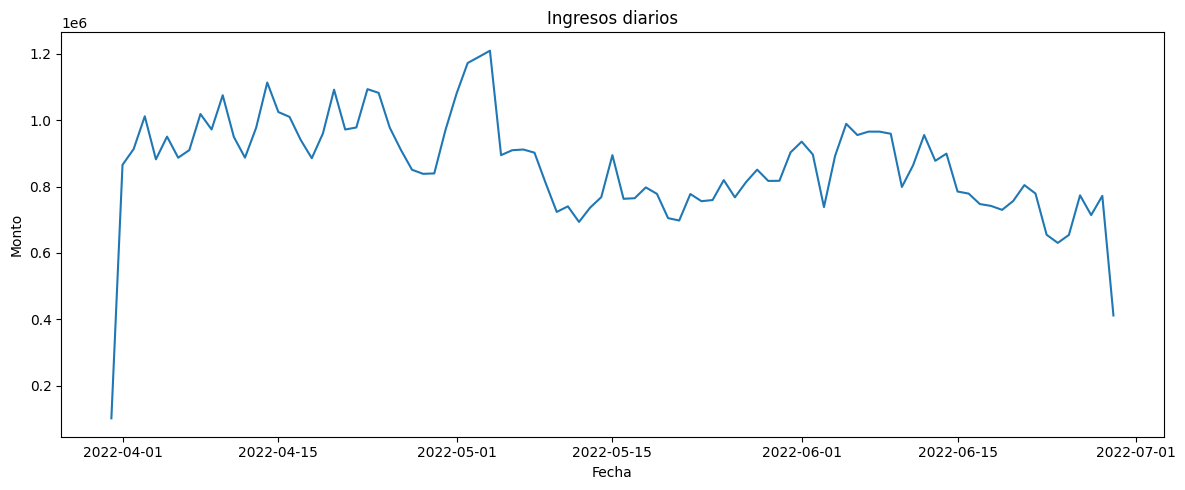

month
2022-03      101683.85
2022-04    28838708.32
2022-05    26226476.75
2022-06    23425809.38
Name: Amount, dtype: float64

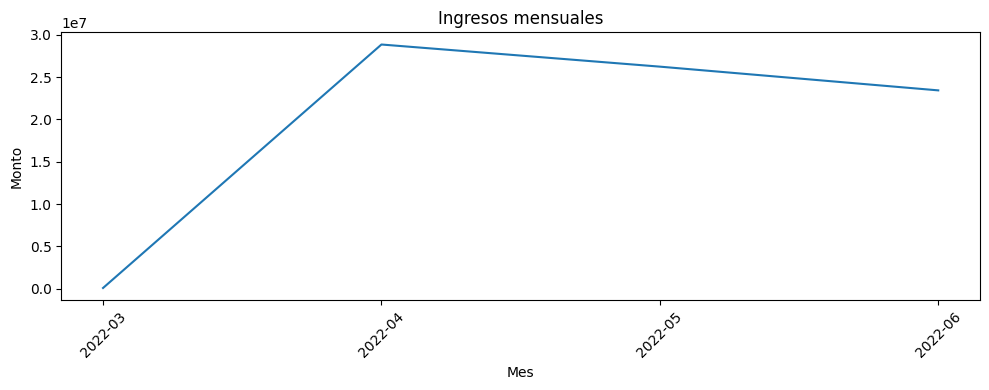

In [7]:
if 'Date' in df_clean.columns:
    df_clean['year'] = df_clean['Date'].dt.year
    df_clean['month'] = df_clean['Date'].dt.to_period('M').astype(str)
    df_clean['day'] = df_clean['Date'].dt.date

    # Ingresos diarios
    if {'Date','Amount'}.issubset(df_clean.columns):
        daily_rev = df_clean.groupby('Date', dropna=True)['Amount'].sum().sort_index()
        display(daily_rev.head())

        # Gráfico - usar matplotlib y no fijar colores específicos
        plt.figure(figsize=(12,5))
        plt.plot(daily_rev.index, daily_rev.values)
        plt.title('Ingresos diarios')
        plt.xlabel('Fecha'); plt.ylabel('Monto')
        plt.tight_layout(); plt.show()

    # Ingresos por mes
    if {'month','Amount'}.issubset(df_clean.columns):
        monthly_rev = df_clean.groupby('month')['Amount'].sum().sort_index()
        display(monthly_rev.tail())

        plt.figure(figsize=(10,4))
        plt.plot(monthly_rev.index, monthly_rev.values)
        plt.title('Ingresos mensuales')
        plt.xticks(rotation=45)
        plt.xlabel('Mes'); plt.ylabel('Monto')
        plt.tight_layout(); plt.show()

## Patrones por categoría, estado y fulfilment

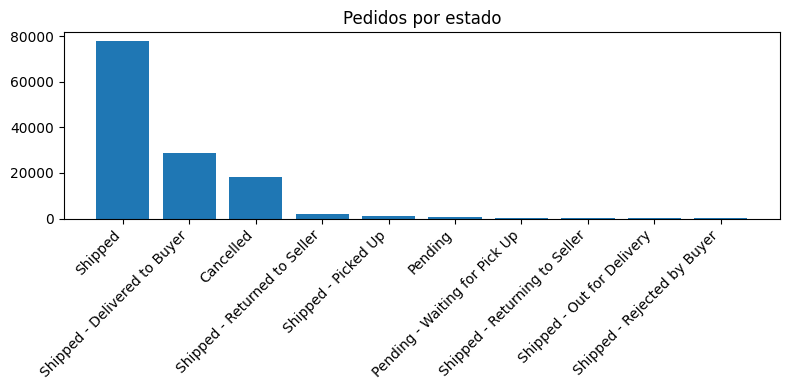

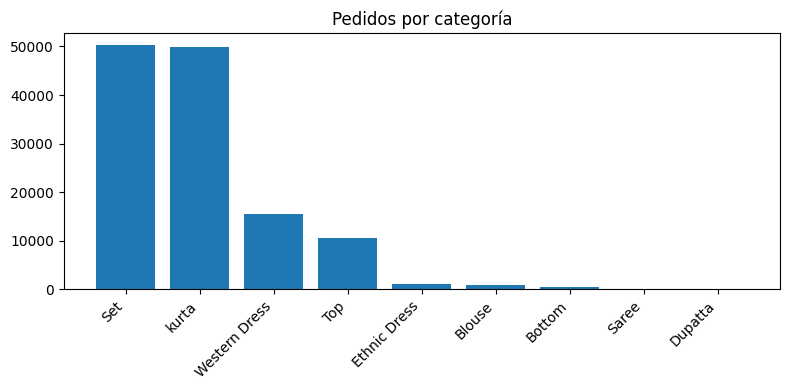

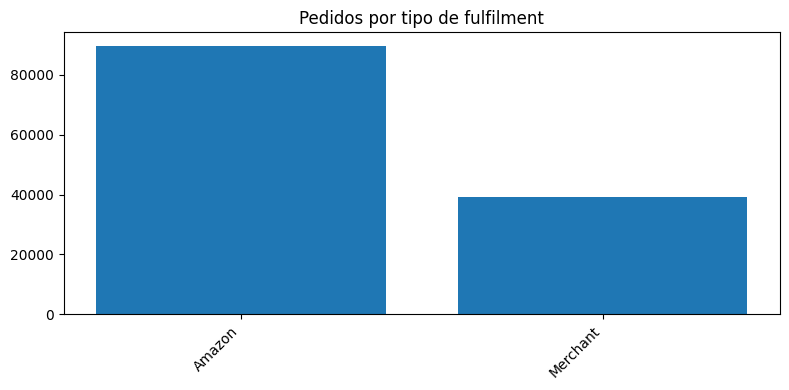

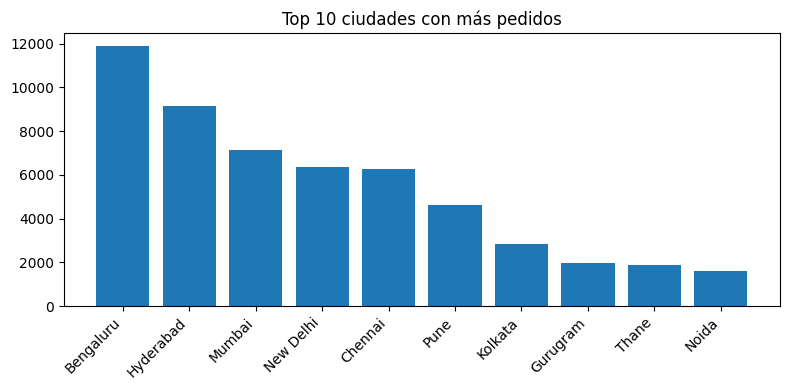

In [8]:
def bar_top(series, title, top=10):
    vc = series.value_counts().head(top)
    plt.figure(figsize=(8,4))
    plt.bar(vc.index.astype(str), vc.values)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

if 'Status' in df_clean.columns:
    bar_top(df_clean['Status'], 'Pedidos por estado')
if 'Category' in df_clean.columns:
    bar_top(df_clean['Category'], 'Pedidos por categoría')
if 'Fulfilment' in df_clean.columns:
    bar_top(df_clean['Fulfilment'], 'Pedidos por tipo de fulfilment')
if 'ship-city' in df_clean.columns:
    bar_top(df_clean['ship-city'], 'Top 10 ciudades con más pedidos', top=10)

## Métricas clave de negocio

In [9]:
metrics = {}
if 'Amount' in df_clean.columns:
    metrics['Ingresos totales'] = float(np.nansum(df_clean['Amount']))
if {'Qty','Amount'}.issubset(df_clean.columns):
    metrics['Ticket promedio (Amount por fila válida)'] = float(np.nanmean(df_clean.loc[df_clean['Amount'].notna(), 'Amount']))
if 'Status' in df_clean.columns:
    total_orders = len(df_clean)
    cancelled = int((df_clean['Status'] == 'Cancelled').sum())
    metrics['% Cancelados'] = round(100*cancelled/total_orders, 2) if total_orders else np.nan

metrics

{'Ingresos totales': 78592678.29999998,
 'Ticket promedio (Amount por fila válida)': 648.5614647631621,
 '% Cancelados': 14.21}

## Insights y observaciones

- **Calidad de datos**: Se detectaron valores nulos en columnas clave (por ejemplo, códigos postales). Se usaron dtypes anulables (`Int64`) para conservar filas sin forzar imputaciones.
- **Temporalidad**: La columna `Date` fue parseada con formato `MM-DD-YY` y `errors='coerce'` para robustez.
- **Ingresos**: Revisar picos y caídas en el gráfico de ingresos diarios/mensuales para asociarlos a campañas o eventos.
- **Cancelaciones**: Ver el porcentaje de pedidos `Cancelled` y cruzarlo con `Fulfilment` o `ship-city` para encontrar focos de mejora logística.
- **Top categorías/ciudades**: Observar qué categorías y ciudades concentran más pedidos para priorizar inventario y campañas.
- **Próximos pasos**: Segmentar por `Courier Status`, analizar `Qty x Amount`, y detectar outliers en montos/qty; agregar mapa si se dispone de coordenadas.

## Export del dataset limpio (CSV)

In [10]:
df_clean['Amount'] = df_clean['Amount'].round(2) # asegurar formato correcto
df_clean.to_csv("Amazon_Sale_Report_CLEAN.csv", index=False, sep=';', decimal=',') # Usar ; como separador y , como decimal
'Archivo exportado: Amazon_Sale_Report_CLEAN.csv'

'Archivo exportado: Amazon_Sale_Report_CLEAN.csv'

In [11]:
# Consolidación final de columnas + export para Tableau
import csv

# Partes de fecha con nombres inequívocos
if 'Date' in df_clean.columns:
    # Asegurar datetime y contar fallas
    dt = pd.to_datetime(df_clean['Date'], format='%m-%d-%y', errors='coerce')
    print("Date inválidas (NaT):", int(dt.isna().sum()))
    df_clean['Date'] = dt

    # Columnas derivadas "claras"
    df_clean['Year_num']  = df_clean['Date'].dt.year
    df_clean['Month_str'] = df_clean['Date'].dt.to_period('M').astype(str)  # 'YYYY-MM'
    df_clean['Day_num']   = df_clean['Date'].dt.day
    df_clean['Date_str']  = df_clean['Date'].dt.strftime('%Y-%m-%d')       # ISO

# Eliminar posibles duplicados de nombres (Year vs year, etc.)
rename_map = {}
for old, new in [
    ('year', 'Year_num'),
    ('Year', 'Year_num'),
    ('month', 'Month_str'),
    ('Month', 'Month_str'),
    ('day', 'Day_num'),
    ('Day', 'Day_num'),
]:
    if old in df_clean.columns and new in df_clean.columns and old != new:
        # Si están ambos, borro el duplicado "old"
        df_clean = df_clean.drop(columns=[old])
    elif old in df_clean.columns and new not in df_clean.columns:
        rename_map[old] = new

if rename_map:
    df_clean = df_clean.rename(columns=rename_map)

# Verificación de unicidad de nombres
n_cols = len(df_clean.columns)
n_unique = df_clean.columns.nunique()
print(f"Columnas totales: {n_cols} | únicas: {n_unique}")
if n_cols != n_unique:
    # Si aún quedara algo duplicado por espacios invisibles, los normalizo
    df_clean.columns = (
        pd.Series(df_clean.columns)
          .str.strip()
          .str.replace(r"\s+", " ", regex=True)
    )
    assert df_clean.columns.nunique() == len(df_clean.columns), "Aún hay nombres duplicados."


#  TSV: evita conflictos de separadores regionales (recomendado si Tableau recorta columnas)
tsv_path = "Amazon_Sale_Report_CLEAN_TABLEAU.tsv"
df_clean.to_csv(
    tsv_path,
    sep='\t',               # DELIMITADOR TAB
    index=False,
    encoding='utf-8',
    quoting=csv.QUOTE_MINIMAL,
    lineterminator='\n'
)
print("TSV exportado:", tsv_path)


Date inválidas (NaT): 0
Columnas totales: 27 | únicas: 27
TSV exportado: Amazon_Sale_Report_CLEAN_TABLEAU.tsv
